## Chapter 4 숫자 이미지 생성하기

In [ ]:
!pip install -q torchinfo

In [ ]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import os
from torchvision.datasets.mnist import MNIST

from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch
from torch import nn, optim
import torchvision
from torchvision.utils import make_grid
from torchinfo import summary

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(is_cuda, device)

True cuda


In [ ]:
seed = 130
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

### 4.2 데이터와 데이터셋

In [ ]:
base_dir = "dataset"

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])
mnist = DataLoader(MNIST(base_dir, train=True, download=True, transform=transform),
                   batch_size=30, shuffle=True)

for images, labels in mnist:
  for i in range(len(images)):
    plt.subplot(3, 10, i+1)
    plt.title(labels[i].item())
    plt.imshow(images[i].squeeze())
    plt.axis("off")
  break

100%|██████████| 9912422/9912422 [00:00<00:00, 95553063.49it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 100778447.44it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30888166.63it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21096931.08it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



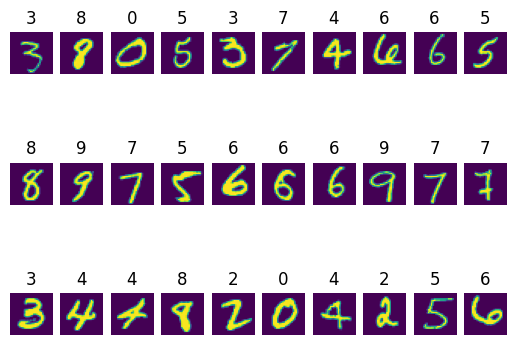

### 4.3 CGAN 모델

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.label_emb = nn.Embedding(10, 10)
    self.model = nn.Sequential(
      nn.Linear(794, 1024),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )

  def forward(self, x, labels):
    x = nn.Flatten()(x)
    c = self.label_emb(labels)
    x = torch.cat([x, c], dim=1)
    out = self.model(x)
    return out.squeeze()

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.label_emb = nn.Embedding(10, 10)
    self.model = nn.Sequential(
      nn.Linear(110, 256),
      nn.LeakyReLU(0.2),
      nn.Linear(256, 512),
      nn.LeakyReLU(0.2),
      nn.Linear(512, 1024),
      nn.LeakyReLU(0.2),
      nn.Linear(1024, 784),
      nn.Tanh()
    )

  def forward(self, z, labels):
    z = nn.Flatten()(z)
    c = self.label_emb(labels)
    x = torch.cat([z, c], 1)
    out = self.model(x)
    return out.reshape(-1, 28, 28)

In [ ]:
dummy_z = torch.randn(1, 100)
dummy_c = torch.randint(0, 10, (1,))
summary(Generator(), input_data=(dummy_z, dummy_c))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 28, 28]               --
├─Embedding: 1-1                         [1, 10]                   100
├─Sequential: 1-2                        [1, 784]                  --
│    └─Linear: 2-1                       [1, 256]                  28,416
│    └─LeakyReLU: 2-2                    [1, 256]                  --
│    └─Linear: 2-3                       [1, 512]                  131,584
│    └─LeakyReLU: 2-4                    [1, 512]                  --
│    └─Linear: 2-5                       [1, 1024]                 525,312
│    └─LeakyReLU: 2-6                    [1, 1024]                 --
│    └─Linear: 2-7                       [1, 784]                  803,600
│    └─Tanh: 2-8                         [1, 784]                  --
Total params: 1,489,012
Trainable params: 1,489,012
Non-trainable params: 0
Total mult-adds (M): 1.49
Input size (MB): 0.00
Forward/bac

In [ ]:
dummy_x = torch.randn(1, 28, 28)
dummy_c = torch.randint(0, 10, (1,))
summary(Discriminator(), input_data=(dummy_x, dummy_c))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Embedding: 1-1                         [1, 10]                   100
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 1024]                 814,080
│    └─ReLU: 2-2                         [1, 1024]                 --
│    └─Linear: 2-3                       [1, 512]                  524,800
│    └─ReLU: 2-4                         [1, 512]                  --
│    └─Linear: 2-5                       [1, 256]                  131,328
│    └─ReLU: 2-6                         [1, 256]                  --
│    └─Linear: 2-7                       [1, 1]                    257
│    └─Sigmoid: 2-8                      [1, 1]                    --
Total params: 1,470,565
Trainable params: 1,470,565
Non-trainable params: 0
Total mult-adds (M): 1.47
Input size (MB): 0.00
Forward/backwa

### 4.4 모델 학습

In [ ]:
def generator_train_step(batch_size, discriminator, generator,
                         g_optimizer, criterion, device):
  z = torch.randn(batch_size, 100).to(device)
  fake_labels = torch.randint(0, 10, (batch_size,)).to(device)

  g_optimizer.zero_grad()

  fake_images = generator(z, fake_labels)
  validity = discriminator(fake_images, fake_labels)

  g_loss = criterion(validity, torch.ones(batch_size).to(device))
  g_loss.backward()
  g_optimizer.step()

  return g_loss.item()

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator,
                             d_optimizer, criterion,
                             images, labels, device):
  d_optimizer.zero_grad()

  # train with real images
  real_validity = discriminator(images.to(device), labels.to(device))
  real_loss = criterion(real_validity, torch.ones(batch_size).to(device))

  # train with fake images
  z = torch.randn(batch_size, 100).to(device)
  fake_labels = torch.randint(0, 10, (batch_size,)).to(device)

  fake_images = generator(z, fake_labels)
  fake_validity = discriminator(fake_images, fake_labels)
  fake_loss = criterion(fake_validity, torch.zeros(batch_size).to(device))

  d_loss = real_loss + fake_loss
  d_loss.backward()
  d_optimizer.step()

  return d_loss.item()

In [ ]:
def train(generator, discriminator, dataloader, criterion,
          g_optimizer, d_optimizer, epoch, device, n_critic=3):

  generator.train()
  discriminator.train()

  running_g_loss = 0
  running_d_loss = 0

  with tqdm(dataloader) as pbar:
    for i, (images, labels) in enumerate(pbar):

      batch_size = len(images)

      # train discriminator in n_critic
      d_loss = 0
      for _ in range(n_critic):
        d_loss += discriminator_train_step(batch_size, discriminator,
                                           generator, d_optimizer, criterion,
                                           images, labels, device)
      d_loss /= n_critic

      # train generator
      g_loss = generator_train_step(batch_size, discriminator, generator,
                                    g_optimizer, criterion, device)

      running_d_loss += d_loss
      running_g_loss += g_loss
      pbar.set_postfix(d_loss=d_loss, g_loss=g_loss)

  return running_d_loss/len(dataloader), running_g_loss/len(dataloader)

In [ ]:
def validation(generator, epoch, device):
  generator.eval()

  z = torch.randn(10, 100).to(device)
  labels = torch.arange(0, 10).to(device)
  images = generator(z, labels).unsqueeze(1)

  grid = make_grid(images, nrow=10, normalize=True)

  fig, ax = plt.subplots(figsize=(10, 1))
  ax.imshow(grid.permute(1, 2, 0).cpu(), cmap='binary')
  ax.axis('off')
  plt.show()

Epoch: 0


100%|██████████| 938/938 [00:43<00:00, 21.81it/s, d_loss=0.0296, g_loss=8.96]


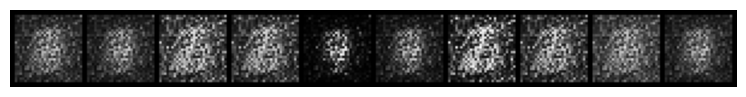

Save Model: 0.0459820439800286
Epoch: 1


100%|██████████| 938/938 [00:44<00:00, 20.86it/s, d_loss=0.0441, g_loss=12.8]


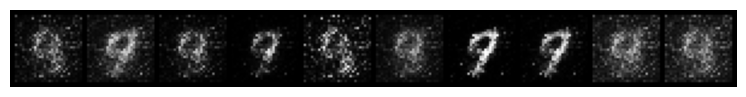

Save Model: 0.019744397711157605
Epoch: 2


100%|██████████| 938/938 [00:44<00:00, 21.06it/s, d_loss=0.0934, g_loss=10.2]


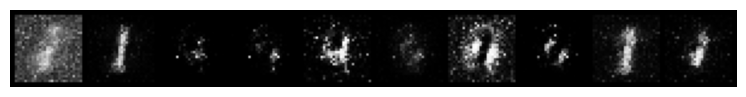

Save Model: 0.024481255084029863
Epoch: 3


100%|██████████| 938/938 [00:44<00:00, 20.89it/s, d_loss=0.00278, g_loss=8.9]


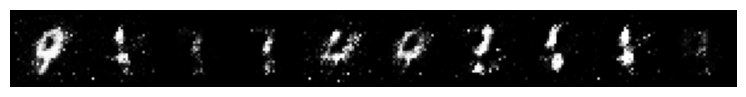

Save Model: 0.024976968071152614
Epoch: 4


100%|██████████| 938/938 [00:45<00:00, 20.84it/s, d_loss=0.00528, g_loss=9.42]


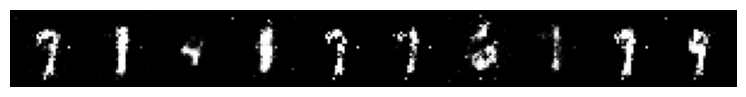

Save Model: 0.03908205203301058
Epoch: 5


100%|██████████| 938/938 [00:45<00:00, 20.58it/s, d_loss=0.0321, g_loss=10.3]


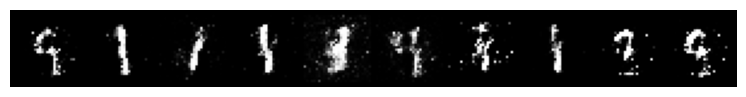

Save Model: 0.04887077405794409
Epoch: 6


100%|██████████| 938/938 [00:46<00:00, 20.22it/s, d_loss=0.0718, g_loss=6.14]


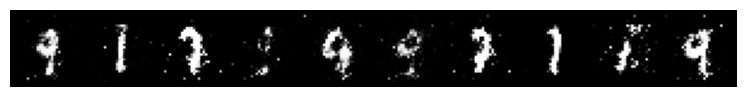

Save Model: 0.059690179362637936
Epoch: 7


100%|██████████| 938/938 [00:46<00:00, 20.09it/s, d_loss=0.0217, g_loss=8.07]


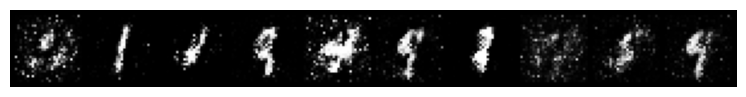

Save Model: 0.06431454693132063
Epoch: 8


100%|██████████| 938/938 [00:47<00:00, 19.95it/s, d_loss=0.0742, g_loss=8.16]


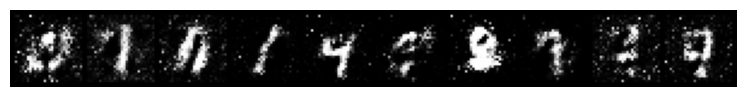

Save Model: 0.09338688256987512
Epoch: 9


100%|██████████| 938/938 [00:47<00:00, 19.90it/s, d_loss=0.14, g_loss=8.03]


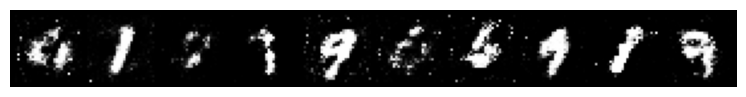

Save Model: 0.1198735387694003
Epoch: 10


100%|██████████| 938/938 [00:47<00:00, 19.61it/s, d_loss=0.159, g_loss=6.36]


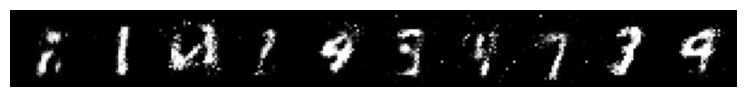

Save Model: 0.14402302695172173
Epoch: 11


100%|██████████| 938/938 [00:47<00:00, 19.66it/s, d_loss=0.14, g_loss=4.7]


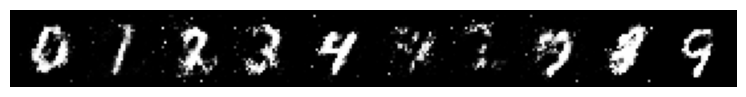

Save Model: 0.18264311829855873
Epoch: 12


100%|██████████| 938/938 [00:47<00:00, 19.74it/s, d_loss=0.0538, g_loss=7.42]


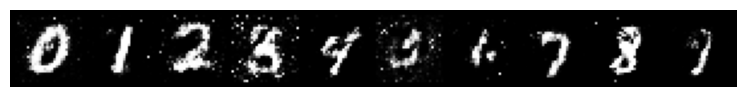

Save Model: 0.203010923013504
Epoch: 13


100%|██████████| 938/938 [00:47<00:00, 19.60it/s, d_loss=0.288, g_loss=5.99]


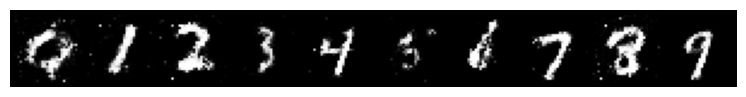

Save Model: 0.2525345030544533
Epoch: 14


100%|██████████| 938/938 [00:48<00:00, 19.50it/s, d_loss=0.355, g_loss=3.49]


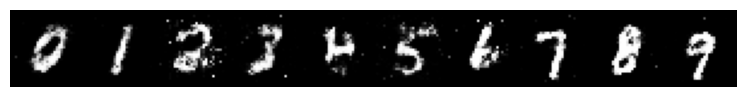

Save Model: 0.29397027262969067
Epoch: 15


100%|██████████| 938/938 [00:48<00:00, 19.46it/s, d_loss=0.274, g_loss=3.61]


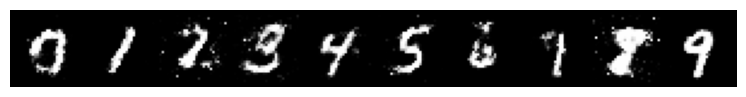

Save Model: 0.3249799804392652
Epoch: 16


100%|██████████| 938/938 [00:48<00:00, 19.38it/s, d_loss=0.347, g_loss=3.53]


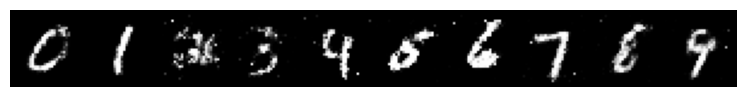

Save Model: 0.3726850115080501
Epoch: 17


100%|██████████| 938/938 [00:48<00:00, 19.18it/s, d_loss=0.201, g_loss=3.99]


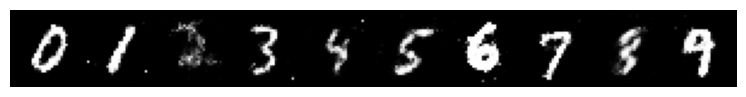

Save Model: 0.39796014564759136
Epoch: 18


100%|██████████| 938/938 [00:48<00:00, 19.27it/s, d_loss=0.39, g_loss=3.47]


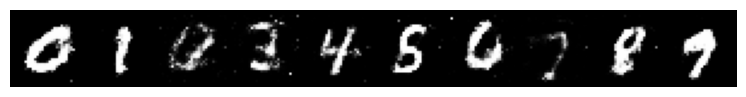

Save Model: 0.42448126683230064
Epoch: 19


100%|██████████| 938/938 [00:49<00:00, 18.93it/s, d_loss=0.447, g_loss=3.42]


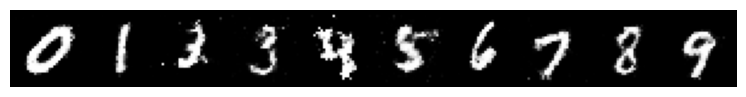

Save Model: 0.46150603063706447
Epoch: 20


100%|██████████| 938/938 [00:48<00:00, 19.23it/s, d_loss=0.384, g_loss=3.82]


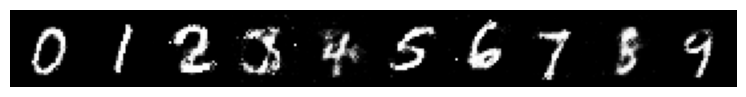

Save Model: 0.485938209130058
Epoch: 21


100%|██████████| 938/938 [00:49<00:00, 19.08it/s, d_loss=0.444, g_loss=3.67]


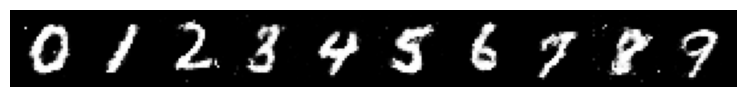

Save Model: 0.5086668682505073
Epoch: 22


100%|██████████| 938/938 [00:49<00:00, 19.08it/s, d_loss=0.488, g_loss=3.5]


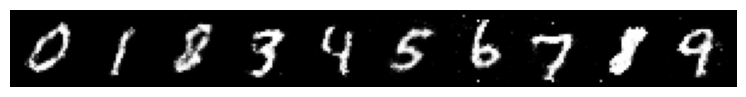

Save Model: 0.5207721290875597
Epoch: 23


100%|██████████| 938/938 [00:49<00:00, 18.84it/s, d_loss=0.417, g_loss=2.86]


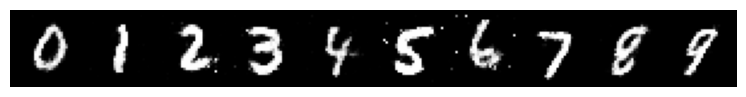

Save Model: 0.5322540683373966
Epoch: 24


100%|██████████| 938/938 [00:49<00:00, 18.83it/s, d_loss=0.442, g_loss=2.78]


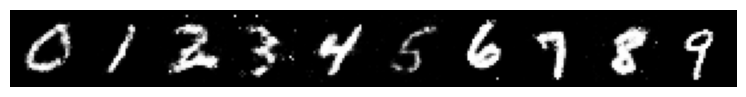

Save Model: 0.5377256654377687
Epoch: 25


100%|██████████| 938/938 [00:50<00:00, 18.75it/s, d_loss=0.627, g_loss=2.79]


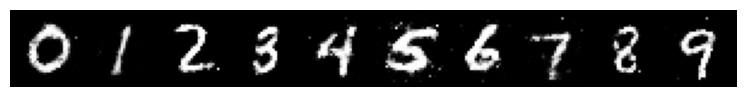

Save Model: 0.5538750915702721
Epoch: 26


100%|██████████| 938/938 [00:49<00:00, 18.78it/s, d_loss=0.732, g_loss=2.41]


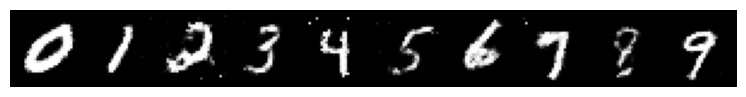

Save Model: 0.5707750732329349
Epoch: 27


100%|██████████| 938/938 [00:50<00:00, 18.70it/s, d_loss=0.597, g_loss=2.82]


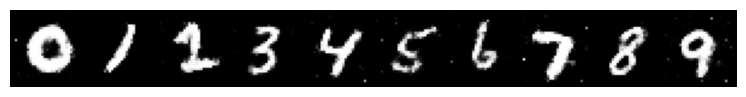

Save Model: 0.575071446524501
Epoch: 28


100%|██████████| 938/938 [00:50<00:00, 18.62it/s, d_loss=0.523, g_loss=2.43]


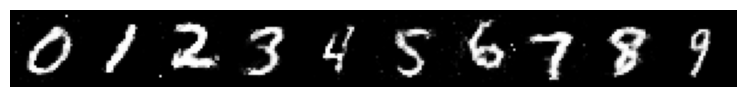

Save Model: 0.5839198991688068
Epoch: 29


100%|██████████| 938/938 [00:50<00:00, 18.54it/s, d_loss=0.576, g_loss=3.23]


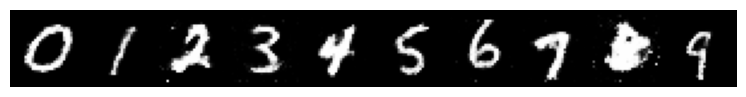

Save Model: 0.5867553841584786


In [ ]:
EPOCH = 30
BATCH_SIZE = 64
NUM_WORKERS = 2
LR = 0.0001

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])
train_loader = DataLoader(
    MNIST(base_dir, train=True, download=True, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss().to(device)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=LR)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LR)

# Start Training
for epoch in range(EPOCH):
  print(f"Epoch: {epoch}")

  gloss, dloss = train(generator, discriminator, train_loader, criterion,
                       g_optimizer, d_optimizer, epoch, device)

  validation(generator, epoch, device)

print(f"Save Model: {gloss}")
torch.save(generator.state_dict(), "last.pth")

### 4.5 추론

(-0.5, 301.5, 301.5, -0.5)

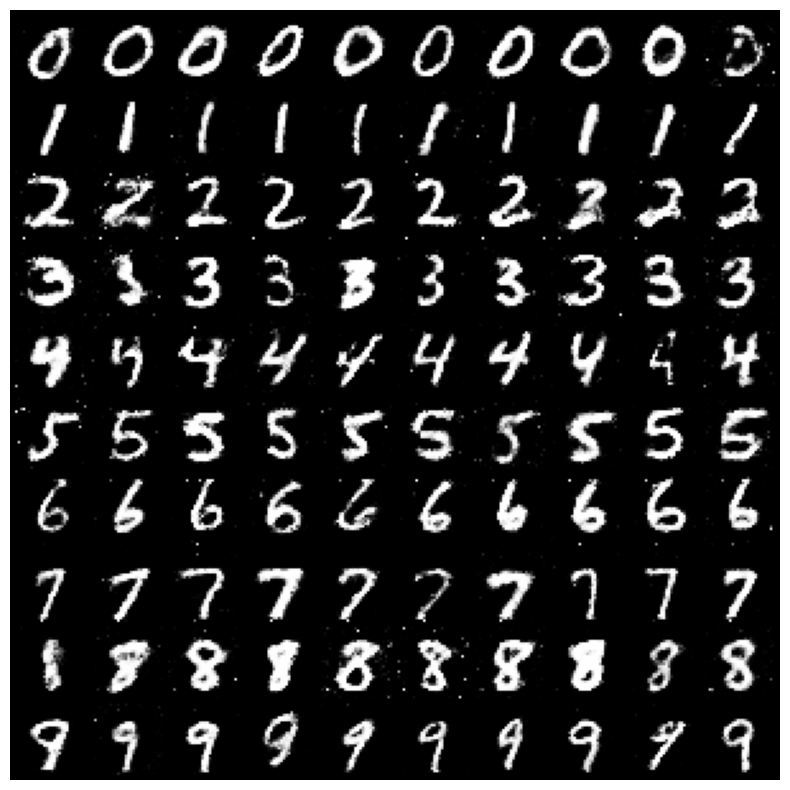

In [ ]:
z = torch.randn(100, 100).to(device)
labels = (torch.arange(0, 100) // 10).cuda()

with torch.no_grad():
  images = generator(z, labels).unsqueeze(1)

grid = make_grid(images, nrow=10, normalize=True)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).cpu(), cmap='binary')
ax.axis('off')